# Chat Agent Executor

In this example we will build a ReAct Agent that uses function calling from scratch.

In [1]:
import os
from dotenv import load_dotenv

# Load the environment variables from the .env file
load_dotenv()

# Access the environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')
tavily_api_key = os.getenv('TAVILY_API_KEY')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')


## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use create a placeholder search engine.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/v0.2/docs/how_to/custom_tools) on how to do that.


In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

We can now wrap these tools in a simple ToolExecutor.
This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output.
A ToolInvocation is any class with `tool` and `tool_input` attribute.


In [3]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

/var/folders/d1/dvmxg7g54gq4h4s6pjdf618w0000gn/T/ipykernel_57453/780962383.py:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.


In [21]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [22]:
model = model.bind_tools(tools)

## Define the agent state

The main type of graph in `langgraph` is the [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph).
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is always added to.


In [23]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.


In [24]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [30]:
# Human in the loop

# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_call = last_message.tool_calls[0]
    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    response = input(prompt=f"[y/n] continue with {action}?")
    if response == "n":
        raise ValueError("User chose to stop")
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = ToolMessage(
        content=str(response), name=action.tool, tool_call_id=tool_call["id"]
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

## Define the graph

We can now put it all together and define the graph!

In [31]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

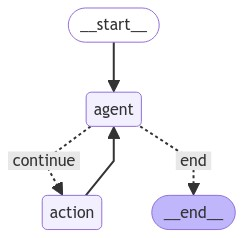

In [32]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel) as all other LangChain runnables.

In [35]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
app.invoke(inputs)

/var/folders/d1/dvmxg7g54gq4h4s6pjdf618w0000gn/T/ipykernel_47861/2367533552.py:11: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


This may take a little bit - it's making a few calls behind the scenes.
In order to start seeing some intermediate results as they happen, we can use streaming - see below for more information on that.

## Streaming

LangGraph has support for several different types of streaming.

### Streaming Node Output

One of the benefits of using LangGraph is that it is easy to stream output as it's produced by each node.


In [28]:
inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_NL8UTrwH3nNLgh7DPl4GsGd9', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-7ea473a1-7b54-43bb-98b4-133dc2e781fa-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_NL8UTrwH3nNLgh7DPl4GsGd9', 'type': 'tool_call'}])]}

---



/var/folders/d1/dvmxg7g54gq4h4s6pjdf618w0000gn/T/ipykernel_47861/2875896790.py:34: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


Output from node 'action':
---
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1725379484, \'localtime\': \'2024-09-03 09:04\'}, \'current\': {\'last_updated_epoch\': 1725379200, \'last_updated\': \'2024-09-03 09:00\', \'temp_c\': 17.2, \'temp_f\': 63.0, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 10, \'wind_dir\': \'N\', \'pressure_mb\': 1014.0, \'pressure_in\': 29.95, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 81, \'cloud\': 0, \'feelslike_c\': 17.2, \'feelslike_f\': 63.0, \'windchill_c\': 17.9, \'windchill_f\': 64.3, \'heatindex_c\': 17.9, \'heatindex_f\': 64.2, \'dewpoint_c\': 11.1, \

### Streaming LLM Tokens

You can also access the LLM tokens as they are produced by each node. 
In this case only the "agent" node produces LLM tokens.
In order for this to work properly, you must be using an LLM that supports streaming as well as have set it when constructing the LLM (e.g. `ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)`)


In [29]:
inputs = {"messages": [HumanMessage(content="what is the weather in sf?")]}

async for output in app.astream_log(inputs, include_types=["llm"]):
    # astream_log() yields the requested logs (here LLMs) in JSONPatch format
    for op in output.ops:
        if op["path"] == "/streamed_output/-":
            # this is the output from .stream()
            ...
        elif op["path"].startswith("/logs/") and op["path"].endswith(
            "/streamed_output/-"
        ):
            # because we chose to only include LLMs, these are LLM tokens
            print(op["value"])

content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_fiTxmBzW15QMUlGHwKSXaUOF', 'function': {'arguments': '', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} id='run-2288ef85-3e0b-46f5-bbf0-2daaf1d68448' tool_calls=[{'name': 'tavily_search_results_json', 'args': {}, 'id': 'call_fiTxmBzW15QMUlGHwKSXaUOF', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'tavily_search_results_json', 'args': '', 'id': 'call_fiTxmBzW15QMUlGHwKSXaUOF', 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': None, 'function': {'arguments': '{"', 'name': None}, 'type': None}]} id='run-2288ef85-3e0b-46f5-bbf0-2daaf1d68448' tool_calls=[{'name': '', 'args': {}, 'id': None, 'type': 'tool_call'}] tool_call_chunks=[{'name': None, 'args': '{"', 'id': None, 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': None, 'function': {'arguments': 'query', 'name': None}, 'type': None}]} id='run-2

/var/folders/d1/dvmxg7g54gq4h4s6pjdf618w0000gn/T/ipykernel_47861/2875896790.py:34: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


content='' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content='The' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' current' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' weather' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' in' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' San' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' Francisco' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' is' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' as' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' follows' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=':\n' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content='-' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' Temperature' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=':' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content=' ' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content='63' id='run-bd70b46e-597b-4122-9c00-f128f85200cb'
content='.' id='ru